In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#To use double-precision numbers: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random, vmap, nn
from patch_gnn.seqops import one_hot
from patch_gnn.graph import graph_tensors,stack_feature_tensors
from patch_gnn.layers import concatenate_node_features,get_norm_attn_matrix,softmax_on_non_zero
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import jax.numpy as jnp
import numpy as np

pd.set_option('display.max_rows', 100)
from jax.config import config 
config.update("jax_debug_nans", True)

#### The goal for this notebook is to test if using (n_node, n_feat) matrix rather than adjacency matrix + feature matrix could give any results

In [4]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

In [5]:
# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


### Convert inputs to (n_graph, max_num_node, num_features)
forget about sasa and fluc features for a sec

In [6]:
train_df, test_df = train_test_split(key, processed_data)
len(train_df), len(test_df)

(251, 108)

In [7]:
train_graph = graph_tensors(train_df, graphs)
test_graph = graph_tensors(test_df, graphs)
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

In [8]:
adj_matrix, feature_matrix = train_graph
adj_matrix.shape, feature_matrix.shape

((251, 20, 20, 1), (251, 20, 67))

#### GAT

###### recode node_attention and softmax_on_non_zero

In [34]:
from functools import partial

adjacency_matrix = adj_matrix[0,:,:,:]
node_embeddings = feature_matrix[0,:,:]

n_features = 67
n_output_dims = 128
key = random.PRNGKey(12)
k1, k2,k3 = random.split(key, num = 3)
w = random.normal(k1, (n_features, n_output_dims))
a = random.normal(k2, (n_output_dims * 2,))
nfa = random.normal(k3, (n_features,))
nfa.shape, node_embeddings.shape

def node_attention(params, inputs):
    (w, a, nfa), (adjacency_matrix, node_embeddings) = params, inputs
    node_feat_attn = vmap(partial(jnp.multiply, jnp.abs(nfa)))(node_embeddings)
    node_projection = jnp.dot(
            node_feat_attn, w
        )
    #print(node_projection.shape)
    node_by_node_concat = concatenate_node_features(
            node_projection
        )
    #print(node_by_node_concat.shape)
    projection = jnp.dot(node_by_node_concat, a)
    #print(projection.shape)
    atten_leaky_relu = nn.leaky_relu(projection, negative_slope=0.1)#******

    atten_leaky_relu = jnp.squeeze(atten_leaky_relu)
    attention = atten_leaky_relu * jnp.squeeze(#****
                    adjacency_matrix#****
                    )
    norm_attention = softmax_on_non_zero(attention)
    return norm_attention, node_projection

In [35]:
from patch_gnn.models import DeepGAT
model = DeepGAT(node_feature_shape=(20, 67), num_adjacency=1, num_training_steps=5000)
#attentions, output = vmap(partial(node_attention, model.params[0]))(train_graph)
train_adj, train_feature= train_graph
print(train_adj.shape, train_feature.shape)
attentions = []
outputs = []
for graph in range(train_adj.shape[0]):
    attention1, output1 = partial(node_attention, model.params[0])((train_adj[graph,:,:,:], 
                                                                train_feature[graph,:,:]))
    attentions.append(attention1)
    outputs.append(output1)
attentions_out = np.stack(attentions)
outputs_out = np.stack(outputs)
attentions_out.shape, outputs_out.shape

(251, 20, 20, 1) (251, 20, 67)


((251, 20, 20), (251, 20, 256))

In [39]:
from functools import partial
import seaborn as sns
from patch_gnn.models import DeepGAT
from patch_gnn.layers import concatenate_node_features, node_attention

In [40]:
model = DeepGAT(node_feature_shape=(20, 67), num_adjacency=1, num_training_steps=5000)
attentions = []
outputs = []
for graph in range(train_adj.shape[0]):
    attention1, output1 = partial(node_attention, model.params[0])((train_adj[graph,:,:,:], 
                                                                train_feature[graph,:,:]))
    attentions.append(attention1)
    outputs.append(output1)
attentions = np.stack(attentions)
outputs = np.stack(outputs)
attentions.shape, outputs.shape

((251, 20, 20), (251, 20, 256))

In [41]:
model.params[0][0]

DeviceArray([[-0.02560492, -0.00924249, -0.0045675 , ...,  0.00373779,
              -0.00339509,  0.01489962],
             [ 0.00414905,  0.01542737, -0.01743275, ...,  0.00212588,
               0.00288546,  0.00363956],
             [ 0.00732468, -0.00153784, -0.01622383, ..., -0.00479539,
               0.00045189,  0.00337567],
             ...,
             [-0.00760192, -0.00677182,  0.01236274, ..., -0.00971496,
               0.00479079, -0.00768552],
             [-0.02179639,  0.01401106, -0.00445629, ...,  0.01537564,
               0.00787088,  0.00836402],
             [ 0.0008844 ,  0.00592836, -0.00128998, ...,  0.00443935,
              -0.00514845, -0.00535213]], dtype=float64)

Take a look at node attention before training

<AxesSubplot:>

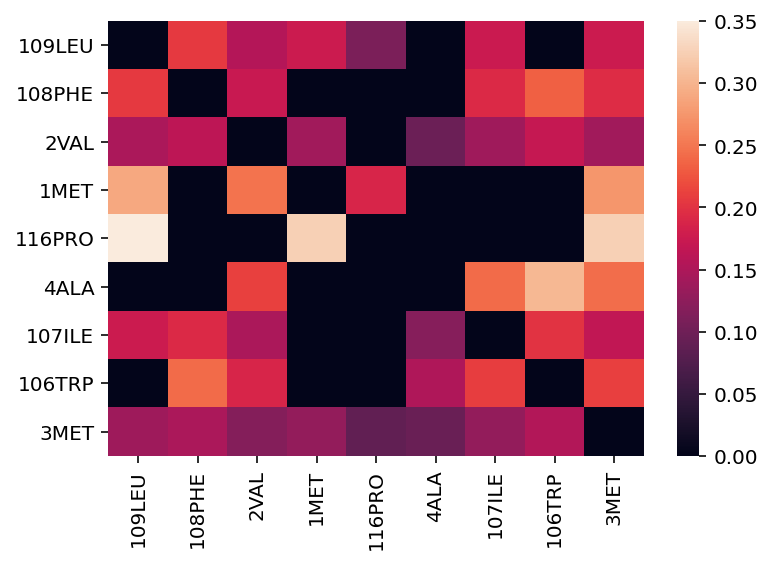

In [42]:
labels = list(graphs[train_df["accession-sequence"].tolist()[1]].nodes())
sns.heatmap(attentions[1, :len(labels), :len(labels)], xticklabels = labels, yticklabels= labels)

##### Get the adjacency matrix of this graph

<AxesSubplot:>

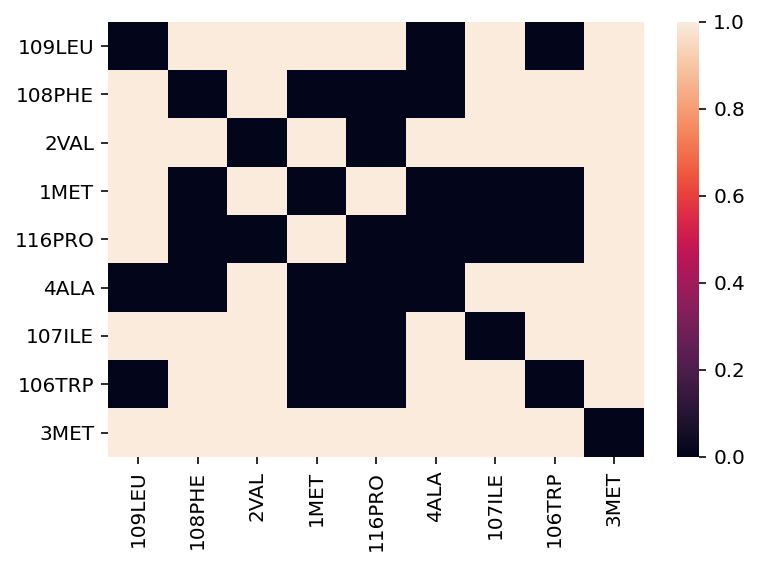

In [43]:
i= 1
labels = list(graphs[train_df["accession-sequence"].tolist()[1]].nodes())
num_nodes = len(labels)
plt.figure()
sns.heatmap(adj_matrix[i,:num_nodes,:num_nodes, :].squeeze(),
            xticklabels = labels, 
            yticklabels= labels)

train model

In [45]:
model.fit(train_graph, train_target)

  0%|          | 0/5000 [00:00<?, ?it/s]

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int64[])>with<BatchTrace(level=3/1)>
  with val = Traced<ShapedArray(int64[251])>with<DynamicJaxprTrace(level=0/1)>
       batch_dim = 0
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [15]:
model.params[0][0]

DeviceArray([[-0.02677356, -0.00949929, -0.00459459, ...,  0.00377472,
              -0.00313778,  0.01481487],
             [ 0.00283899,  0.01513463, -0.01735751, ...,  0.00231611,
               0.00314315,  0.00357616],
             [ 0.00456509, -0.00248521, -0.01622147, ..., -0.00460627,
               0.00095323,  0.00326079],
             ...,
             [-0.01132415, -0.00794116,  0.01237822, ..., -0.00955379,
               0.00549968, -0.00794959],
             [-0.03411884,  0.00661387, -0.00303516, ...,  0.01953342,
               0.00821075,  0.00453427],
             [ 0.01765647,  0.01616336, -0.00031143, ...,  0.00517127,
              -0.01363394, -0.00442324]], dtype=float64)

In [16]:
checkpoint = -1
preds = model.predict(test_graph, checkpoint=checkpoint)
train_preds = model.predict(train_graph, checkpoint=checkpoint)

Text(0.5, 1.0, 'Test target vs. test pred')

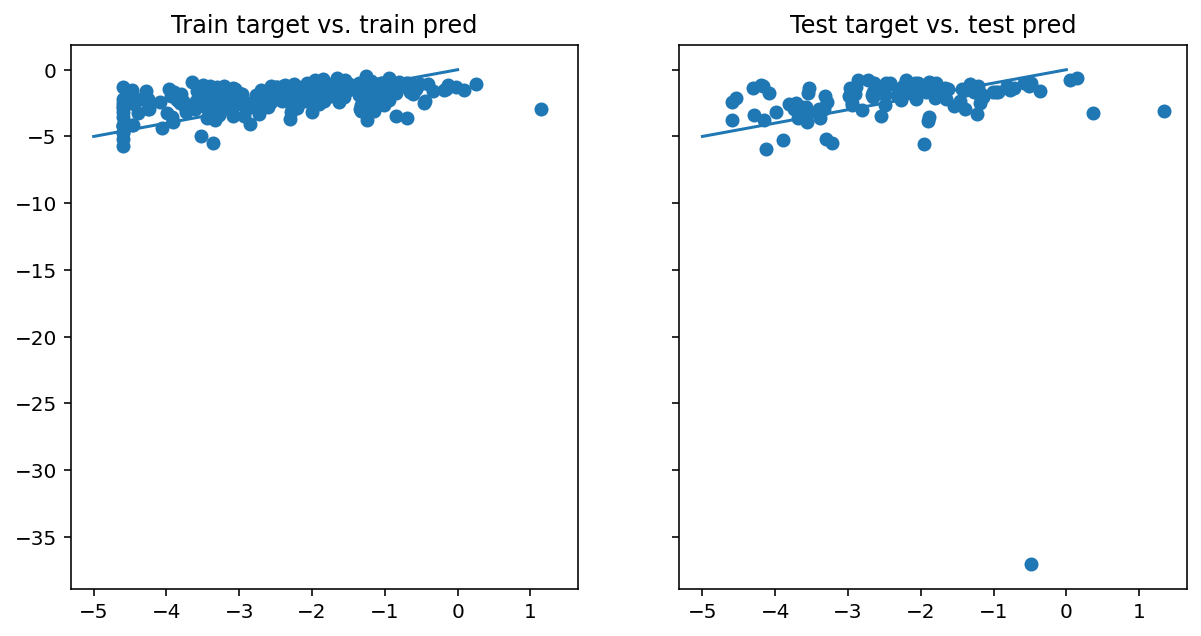

In [17]:
fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )
ax[0].scatter(train_target.squeeze(), train_preds.squeeze())
ax[0].plot([-5, 0], [-5, 0])
ax[0].set_title("Train target vs. train pred")
ax[1].scatter(test_target.squeeze(), preds.squeeze())
ax[1].plot([-5, 0], [-5, 0])
ax[1].set_title("Test target vs. test pred")

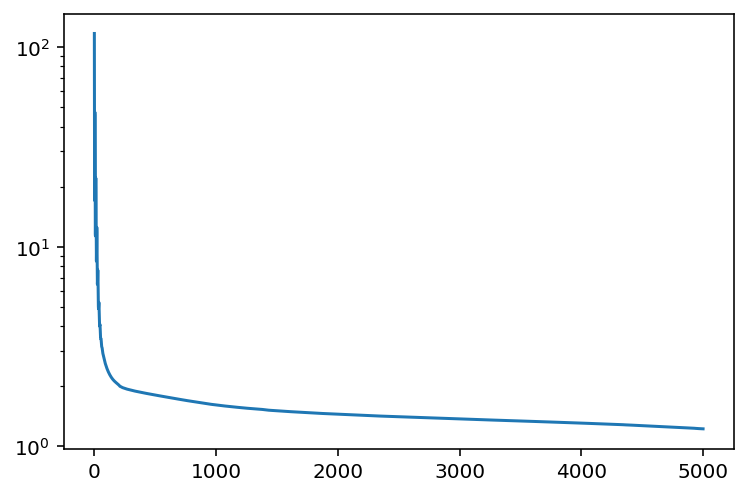

In [18]:
plt.plot(model.loss_history)
plt.yscale("log")

In [19]:
from tqdm.auto import tqdm
from sklearn.metrics import explained_variance_score as evs, r2_score as r2
from jax import jit
def learning_curves(model, data, score_func, *, interval: int=20):
    X, y = data
    scores = []
    for i in tqdm(range(len(model.loss_history))[::interval]):
        preds = model.predict(X, checkpoint=i)
        score = score_func(y.squeeze(), preds.squeeze())
        scores.append(score)
    return scores

In [22]:
interval = 1
train_score = learning_curves(model, (train_graph, train_target), r2, interval=interval)
test_score = learning_curves(model, (test_graph, test_target), r2, interval=interval)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'r2')

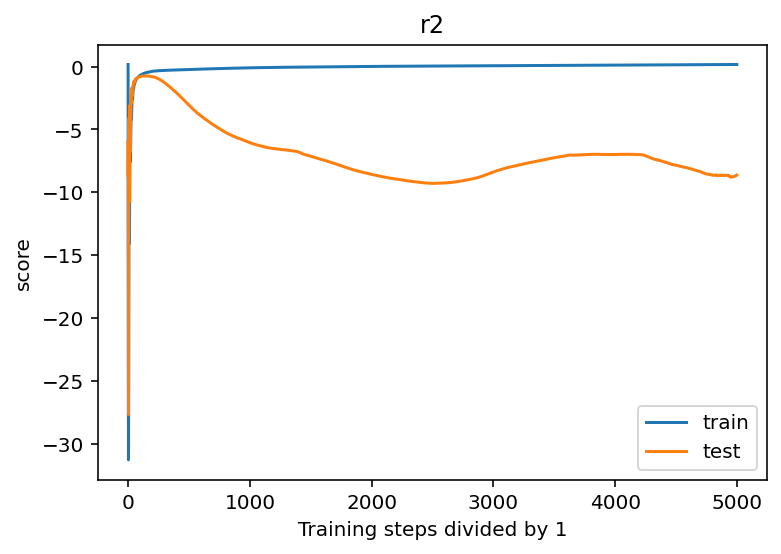

In [23]:
plt.plot(train_score, label="train")
plt.plot(test_score, label="test")
plt.legend()
plt.xlabel(f"Training steps divided by {interval}")
plt.ylabel("score")
plt.title("r2")

In [25]:
r2(train_target.squeeze(), train_preds.squeeze()), evs(train_target.squeeze(), train_preds.squeeze())

(0.1640258534955915, 0.19050239285786863)

### Explore what’s learned by GATs

(251, 20, 20)

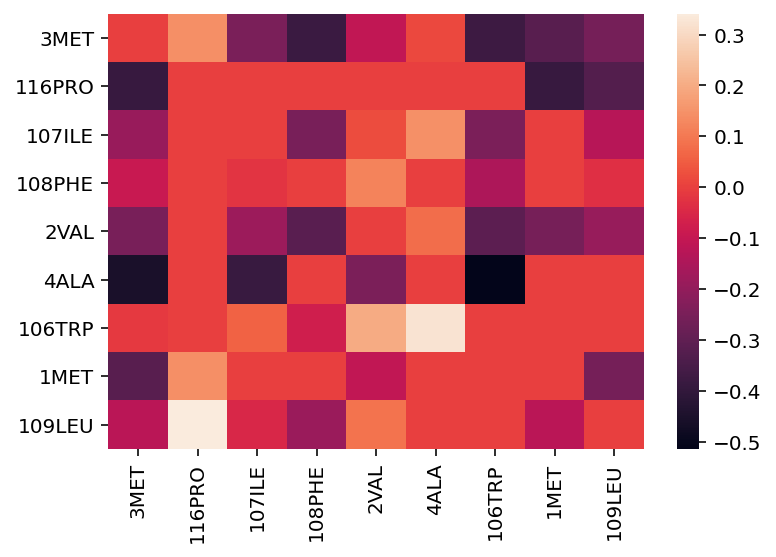

In [26]:
attentions, output = vmap(partial(node_attention, model.params[0]))(train_graph)
#ax = sns.heatmap(attentions[idx][0:len(g.nodes()), 0:len(g.nodes())], cmap="viridis")
#ax.set_xticklabels(list(g.nodes()), rotation = 90)
#ax.set_yticklabels(list(g.nodes()), rotation = 0)
labels = list(graphs[train_df["accession-sequence"].tolist()[1]].nodes())
sns.heatmap(attentions[1, :len(labels), :len(labels)], xticklabels = labels, yticklabels= labels)
attentions.shape

In [28]:
attentions[0, :len(labels), :len(labels)]

DeviceArray([[-0.        , -0.        , -0.45500479, -0.        ,
              -0.38115023, -0.        ,  0.        ,  0.        ,
               0.        ],
             [-0.        , -0.        , -0.49149899, -0.        ,
              -0.        , -0.        ,  0.        ,  0.        ,
               0.        ],
             [ 0.0161095 ,  0.03146893, -0.        , -0.38414377,
              -0.24727503, -0.25258481,  0.        ,  0.        ,
               0.        ],
             [ 0.        ,  0.        , -0.09506065, -0.        ,
              -0.02120609, -0.        ,  0.        ,  0.        ,
               0.        ],
             [ 0.14796837,  0.        , -0.18927072, -0.25228489,
              -0.        , -0.        ,  0.        ,  0.        ,
               0.        ],
             [ 0.        ,  0.        , -0.19460422, -0.        ,
              -0.        , -0.        ,  0.        ,  0.        ,
               0.        ],
             [-0.        , -0.        , 

The vertical numbers are not all identical. Keep that in mind.

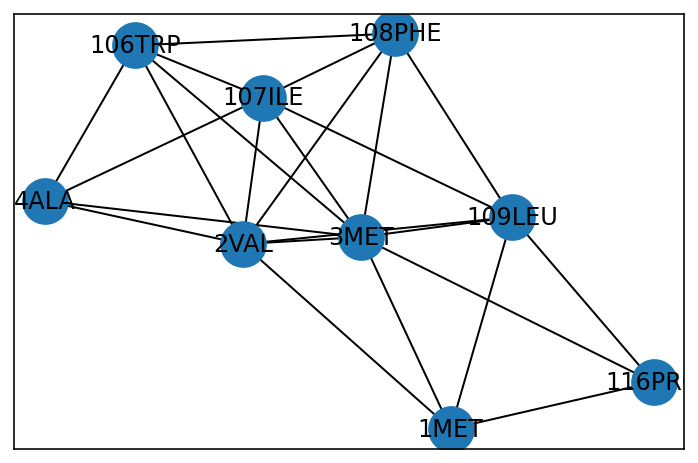

In [13]:
import networkx as nx
nx.draw_networkx(graphs[train_df["accession-sequence"].tolist()[1]], with_labels=True,node_size=500)

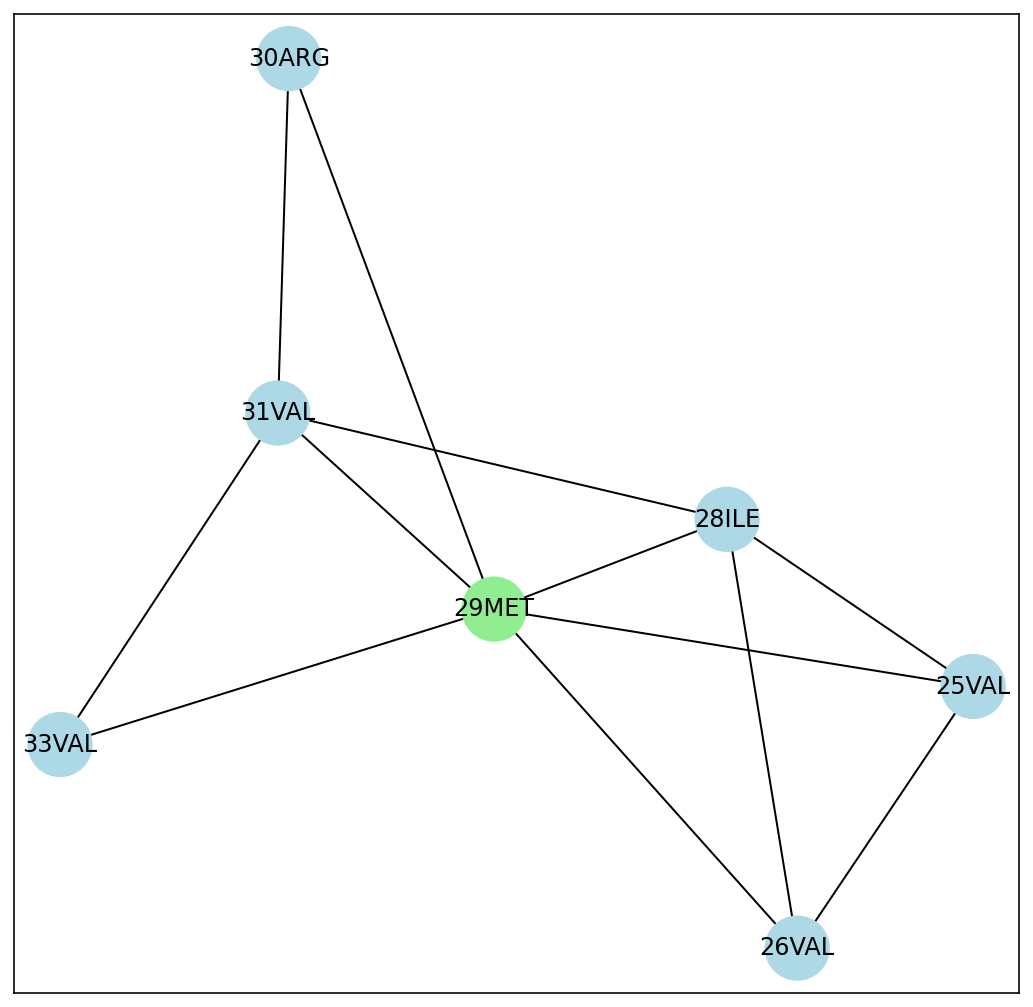

In [31]:
f, axs = plt.subplots(1,1,figsize=(9,9))
nx.draw_networkx(graphs[train_df["accession-sequence"].tolist()[2]], 
                 with_labels=True,node_size =1000,
                node_color = ['lightblue' if 'MET' not in i else 'lightgreen' for i in list(graphs[train_df["accession-sequence"].tolist()[2]].nodes())])

In [27]:
['blue' if 'MET' not in i else 'lightgreen' for i in list(graphs[train_df["accession-sequence"].tolist()[2]].nodes())]


['blue', 'blue', 'lightgreen', 'blue', 'blue', 'blue', 'blue']

In [ ]:
[unicode(x.strip()) if x is not None else '' for x in row]

In [ ]:
from dgl.nn.pytorch.conv import GATConv
gatconv = GATConv(67, 256, num_heads=3)
res = gatconv(graphs, feat)  #the graph has to be graph object from dgl

# GRAVEYARD

In [ ]:
from patch_gnn.layers import normalize_if_nonzero
from jax import grad

In [ ]:
normalize_if_nonzero(p_vect=np.zeros(3))

In [ ]:
a = np.array([0.1, 0.5, 0.0])
normalize_if_nonzero(p_vect=a)

In [ ]:
def f(p):
    p = normalize_if_nonzero(p)
    return np.sum(p)

In [ ]:
f(np.)

In [ ]:
df = grad(f)

In [ ]:
df(np.zeros(3)),  df(a)